In [1]:
import os
import json
from segmentation import vectorize, get_distinctive_glyphs, plot_breakpoints, segment_text
from collocations import get_bigram_collocations, get_trigram_collocations, get_similar_glyphs
from processing import load_file, clean_lines, encode_lines, split_sequences
from nearest_neighbor import analyze_glyphs, glyph_bound
from discourse import plot_discourse
from search import search_glyphs

In [15]:
raw_I_data = load_file('data/I.csv')
clean_I_data = clean_lines(raw_I_data)
encoded_I_data = encode_lines(clean_I_data)
_, sequences_I = split_sequences(encoded_I_data)

In [17]:
bigrams_I = get_bigram_collocations(sequences_I)
bigrams_I

[(('600.6', '<76>'), 86.30998954252766),
 (('90', '<76>'), 80.69157604926488),
 (('430', '<76>'), 44.0694053644971),
 (('76', '<76>'), 18.062969050466),
 (('90.21', '<76>'), 14.891779069435712),
 (('1v', '<76>'), 14.556705531972124),
 (('633', '<76>'), 14.03404598112618),
 (('700', '<76>'), 13.335396136729994),
 (('99', '<76>'), 11.909502012641163),
 (('290.6', '<76>'), 11.162991146924597),
 (('<76>', '532'), 79.579052739205),
 (('<76>', '11'), 55.05459105649753),
 (('<76>', '71'), 54.79019222974357),
 (('<76>', '70'), 43.15166140418751),
 (('<76>', '75'), 27.425894654315442),
 (('<76>', '4f'), 25.03275083355652),
 (('<76>', '10.79f'), 20.40770816154103),
 (('<76>', '57'), 18.624479779816035),
 (('<76>', '2a.10'), 18.17225933093974),
 (('<76>', '6'), 18.17225933093974),
 (('600', '</s>'), 30.48681769231336),
 (('90', '</s>'), 17.832184933143072),
 (('59', '</s>'), 15.905211780551396),
 (('2', '</s>'), 13.688962071210824),
 (('270.6', '</s>'), 10.920445049634374),
 (('200.10', '</s>'), 

In [18]:
bigrams_I_frequency = get_bigram_collocations(sequences_I, measure="frequency")
bigrams_I_frequency

[(('90', '<76>'), 49),
 (('600.6', '<76>'), 29),
 (('430', '<76>'), 27),
 (('76', '<76>'), 22),
 (('700', '<76>'), 16),
 (('1v', '<76>'), 12),
 (('71', '<76>'), 12),
 (('2', '<76>'), 10),
 (('200.10', '<76>'), 9),
 (('451', '<76>'), 7),
 (('<76>', '71'), 33),
 (('<76>', '532'), 30),
 (('<76>', '70'), 21),
 (('<76>', '11'), 21),
 (('<76>', '600'), 14),
 (('<76>', '4f'), 11),
 (('<76>', '6'), 10),
 (('<76>', '2a.10'), 10),
 (('<76>', '75'), 9),
 (('<76>', '430'), 8),
 (('90', '</s>'), 29),
 (('600', '</s>'), 24),
 (('76', '</s>'), 18),
 (('2', '</s>'), 14),
 (('700', '</s>'), 13),
 (('200.10', '</s>'), 9),
 (('59', '</s>'), 8),
 (('27', '</s>'), 8),
 (('430', '</s>'), 8),
 (('670', '</s>'), 7)]

In [19]:
trigrams_I = get_trigram_collocations(sequences_I)
trigrams_I

[(('600.6', '<76>', '532'), 167.7774733389341),
 (('90', '<76>', '532'), 161.26209703734247),
 (('90', '<76>', '71'), 136.74940260245918),
 (('90', '<76>', '11'), 136.09630230902766),
 (('600.6', '<76>', '70'), 133.339366361156),
 (('90', '<76>', '70'), 131.9021456495934),
 (('430', '<76>', '532'), 125.98603717421119),
 (('90', '<76>', '21.1'), 113.3689179406339),
 (('600.6', '<76>', '71.61'), 104.72150834586526),
 (('90', '<76>', '57'), 102.09305501814285)]

In [20]:
trigrams_I_frequency = get_trigram_collocations(sequences_I, measure="frequency")
trigrams_I_frequency

[(('90', '<76>', '70'), 7),
 (('755', '<76>', '75'), 5),
 (('90', '<76>', '71'), 5),
 (('430', '<76>', '532'), 4),
 (('90', '<76>', '21.1'), 4),
 (('600.6', '<76>', '70'), 4),
 (('71', '<76>', '10.79f'), 4),
 (('600.6', '<76>', '532'), 4),
 (('200.10', '<76>', '71'), 4),
 (('721', '<76>', '70'), 3)]

In [21]:
_, percentages_I = get_similar_glyphs(sequences_I)
percentages_I

{'XYX': 0.045871559633027525,
 'XXZ': 0.04357798165137615,
 'XYY': 0.027522935779816515}

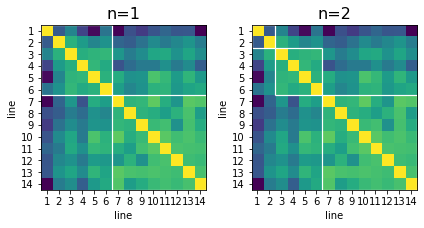

In [22]:
vectorized_text, _ = vectorize(encoded_I_data)
bkpts = plot_breakpoints(vectorized_text, [1, 2])

In [23]:
for bkpt in bkpts:
    segmented_text = segment_text(encoded_I_data, bkpt)
    distinctive_glyphs = get_distinctive_glyphs(segmented_text)
    print(distinctive_glyphs)

[['600', '76', '430', '430.76', '90', '532', '90.76', '700.76', '75', '700'], ['90.76', '71', '11', '76', '532', '600.6.76', '600', '90', '70', '2a.10']]
[['600', '430.76', '700.76', '270.6', '76', '200.6.76', '200.76', '200.513', '2', '200.10'], ['430', '76', '600', '90.76', '90', '430.76', '532', '70', '76.76', '75'], ['90.76', '11', '71', '76', '532', '600.6.76', '600', '90', '2a.10', '70']]


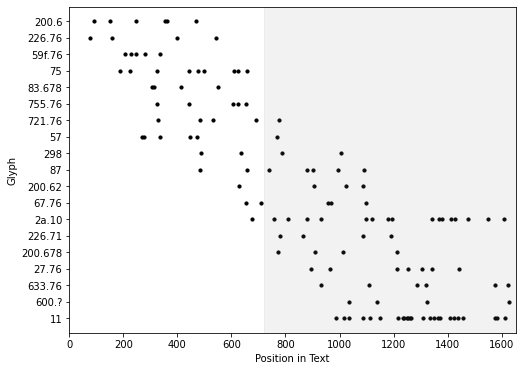

In [24]:
clustered_glyphs, _ = analyze_glyphs(encoded_I_data)
plot_discourse(clustered_glyphs, encoded_I_data, bkpt=bkpts[0][0])

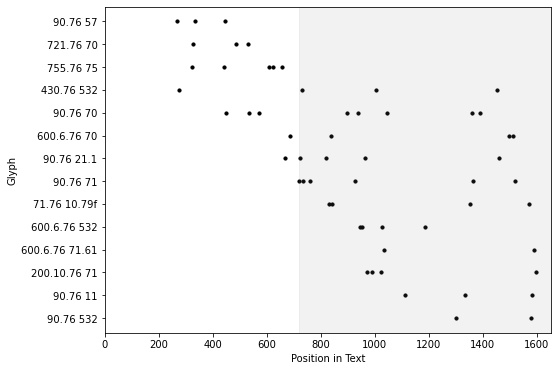

In [26]:
trigrams_formatted = [[f'{trigram[0][0]}.76', trigram[0][2]] for trigram in trigrams_I]
for trigram in trigrams_I_frequency:
    if [f'{trigram[0][0]}.76', trigram[0][2]] not in trigrams_formatted:
        trigrams_formatted.append([f'{trigram[0][0]}.76', trigram[0][2]])
trigrams_sorted = sorted(trigrams_formatted, key=lambda x: glyph_bound(x, encoded_data))
plot_discourse(trigrams_sorted, encoded_I_data, bkpt=bkpts[0][0])

In [27]:
XY = [(trigram[0][0], trigram[0][2]) for trigram in trigrams_I + trigrams_I_frequency]
search_results = search_glyphs(XY)
search_results

{'90 532': ['Aa1', 'Aa2'],
 '90 71': ['Ev2'],
 '90 11': ['Aa2'],
 '90 70': ['Sb8', 'Aa2'],
 '200.10 71': ['Qr7']}

In [28]:
raw_Gv_data = load_file('data/Gv.csv')
clean_Gv_data = clean_lines(raw_Gv_data)
encoded_Gv_data = encode_lines(clean_Gv_data)
_, sequences_Gv = split_sequences(encoded_Gv_data)

In [29]:
bigrams_Gv = get_bigram_collocations(sequences_Gv)
bigrams_Gv

[(('430', '<76>'), 10.304570821078993),
 (('660', '<76>'), 8.628683760603025),
 (('670', '<76>'), 5.048451138739251),
 (('5', '<76>'), 2.6179993043408443),
 (('<76>', '200f'), 17.494269243720588),
 (('<76>', '70'), 8.628683760603025),
 (('32', '</s>'), 8.763398730209968),
 (('90f', '</s>'), 8.628683760603025),
 (('59f', '</s>'), 5.048451138739251),
 (('22', '</s>'), 3.5621668788614578)]

In [31]:
_, percentages_Gv = get_similar_glyphs(sequences_Gv)
percentages_Gv

{'XYX': 0.21875, 'XXZ': 0.0625, 'XYY': 0.09375}

In [32]:
raw_T_data = load_file('data/T.csv')
clean_T_data = clean_lines(raw_T_data)
encoded_T_data = encode_lines(clean_T_data)
_, sequences_T = split_sequences(encoded_T_data)

In [33]:
bigrams_T = get_bigram_collocations(sequences_T)
bigrams_T

[(('430', '<76>'), 4.678702588007328),
 (('<76>', '532'), 8.024679218708592),
 (('<76>', '70'), 4.476845027126553),
 (('<76>', '430'), 1.4889447439826093)]